In [36]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy.optimize as op
import corner

In [37]:
import dust_emissivity

In [38]:
Msun=cte.M_sun
c=cte.c

In [39]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/T1 f2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

v1=[]
ev1=[]

v2=[]
ev2=[]

v3=[]
ev3=[]

l1=[]
el1=[]

l2=[]
el2=[]

l3=[]
el3=[]


for j in rows:   
    
    ID.append(j[0])
    
    v1.append(float(j[3]))
    ev1.append(float(j[4]))
    v2.append(float(j[5]))
    ev2.append(float(j[6]))
    v3.append(float(j[7]))
    ev3.append(float(j[8]))
    l1.append(float(j[9]))
    el1.append(float(j[10]))
    l2.append(float(j[11]))
    el2.append(float(j[12]))
    l3.append(float(j[13]))
    el3.append(float(j[14]))


In [40]:
v_=[148,218,278]*un.GHz
l__=[500,350,250]*un.um
v=v_.to("Hz").value
l_=c/(np.array([500,350,250])*un.um)
l=l_.to("Hz").value
vf=np.concatenate((v, l))

In [41]:
def tau(z,M_,d_,vf): 
    v0=355*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [42]:
def P(vf,T,z):
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [43]:
def modelSv(z,T,M_,d_,vf):
    b=2
    v0=350*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    d=d_
    O=np.pi*(d/2)**2 * (D**-2)
    S_=O*(1-np.e**-tau(z,M_,d_,vf))*P(vf,T,z)
    S=S_.to("mJy")
    return S

In [44]:
#wrapper del modelo

def fit_bb(x, *p):
    #dejar una descripcion de los parametros que entran en la funcion entre comillas al comienzo
    """
    x : frecuencia *un.Hz ------> por alguna razon esto esta en Hz pero el v0 por ejemplo en GHz
    p = z T M d  ---------------> parametros a fitear   
    z : redshift (adimensional)
    T : temperatura en Kelvin pero sin usar unidades
    M : log(mu M/M_sun) (adimensional)
    d : distance *en kpc pero sin usar unidades
    
    return: modelo en mJy pero sin unidades
    """
    #queda definido dentro el valor de b y v0 que no se cambian nunca
    b = 2.0
    v0 = 353*un.GHz
    
    return modelSv(p[0],p[1]*un.K,p[2],p[3]*un.kpc,x)

In [45]:
def lnlike(theta,x,y,yerr):
    lnf,z,T,M,d = theta
    x = x*un.Hz
    modelSv = fit_bb(x,z,T,M,d).value
    inv_sigma2 = 1.0 / (yerr**2 + (modelSv)**2 * np.exp(2*lnf))
    return -0.5 * np.sum((y-(modelSv))**2*inv_sigma2 - np.log(inv_sigma2))

In [46]:
def lnlike_1(theta,x,y,yerr):
    lnf,z,T,M,d = theta
    x = x*un.Hz
    modelSv = fit_bb(x,z,T,M,d).value
    modelSv_corr=np.delete(modelSv,2)
    inv_sigma2 = 1.0 / (yerr**2 + (modelSv_corr)**2 * np.exp(2*lnf))
    return -0.5 * np.sum((y-(modelSv_corr))**2*inv_sigma2 - np.log(inv_sigma2))

In [47]:
def lnprior(theta):
    lnf,z,T,M,d = theta
    if lnf<0 and T>0 and z>0 and M>0 and d>0:
        priorT=-1 * (T - 50)**2 / (2 * 10**2) # T gaussian: median=50, sig=10
        priorM=-1 * (M - 9)**2 / (2 * 0.2**2) # M gaussian: median=9, sig=0.2
        return (priorT,priorM)
    return (-np.inf,-np.inf)

In [48]:
def lnprob(theta, x, y, yerr):
    lp_T = lnprior(theta)[0]
    lp_M = lnprior(theta)[1]
    if lp_T==-np.inf:
        return (-np.inf,lp_M + lnlike(theta, x, y, yerr))
    elif lp_M==-np.inf :
        return (lp_T + lnlike(theta, x, y, yerr),-np.inf)
    elif lp_T==-np.inf and lp_M==-np.inf:
         return (-np.inf,-np.inf)
    return (lp_T + lnlike(theta, x, y, yerr),lp_M + lnlike(theta, x, y, yerr))

In [49]:
def lnprob_1(theta, x, y, yerr): #yo creo que en esta función está el error
    lp_T = lnprior(theta)[0]
    lp_M = lnprior(theta)[1]
    if lp_T==-np.inf:
        return (-np.inf,lp_M + lnlike_1(theta, x, y, yerr))
    elif lp_M==-np.inf :
        return (lp_T + lnlike_1(theta, x, y, yerr),-np.inf)
    elif lp_T==-np.inf and lp_M==-np.inf:
         return (-np.inf,-np.inf)
    return (lp_T + lnlike_1(theta, x, y, yerr),lp_M + lnlike_1(theta, x, y, yerr))

In [50]:
z_ref=3.4
T_ref=52.1*un.K
M_ref=9.50
d_ref=3.8*un.kpc

In [51]:
def ml(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x0,y,label="MaxL")
    plt.errorbar(vf,np.array(frecsT),yerr=np.array(errfT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(zm,2),np.round(Tm,2),np.round(Mm,2),np.round(dm,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [52]:
def ml_1(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike_1(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x0,y,label="MaxL")
    plt.errorbar(np.delete(vf,2),np.array(frecsT),yerr=np.array(errfT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(zm,2),np.round(Tm,2),np.round(Mm,2),np.round(dm,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [53]:
def mcmc(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1.1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 5, 6000 # 6000 iteraciones
    pos = [maxlike["x"] + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)] #^5 por numero de dim
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=(vf,np.array(frecsT),np.array(errfT)),
                                threads=2)
    sampler.run_mcmc(pos, 16) #16 chains
    samples = sampler.chain[:, 2:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["ln","z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[lnfM,zm,Tm,Mm,dm])

In [54]:
def mcmc_1(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1.1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike_1(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])


    ndim, nwalkers = 5, 6000 # 6000 iteraciones
    pos = [maxlike["x"] + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_1,args=(vf,np.array(frecsT),np.array(errfT)),
                                threads=2)
    sampler.run_mcmc(pos, 16) #16 chains
    samples = sampler.chain[:, 2:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["ln","z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[lnfM,zm,Tm,Mm,dm])

ACT-S J0011-0018

In [55]:
frecs0T=np.array([v1[0],v2[0],v3[0],l1[0],l2[0],l3[0]])
errf0T=np.array([ev1[0],ev2[0],ev3[0],el1[0],el2[0],el3[0]])

In [56]:
frecs0=np.array([[v1[0],v2[0],v3[0]],[l1[0],l2[0],l3[0]]])
errf0=np.array([[ev1[0],ev2[0],ev3[0]],[el1[0],el2[0],el3[0]]])

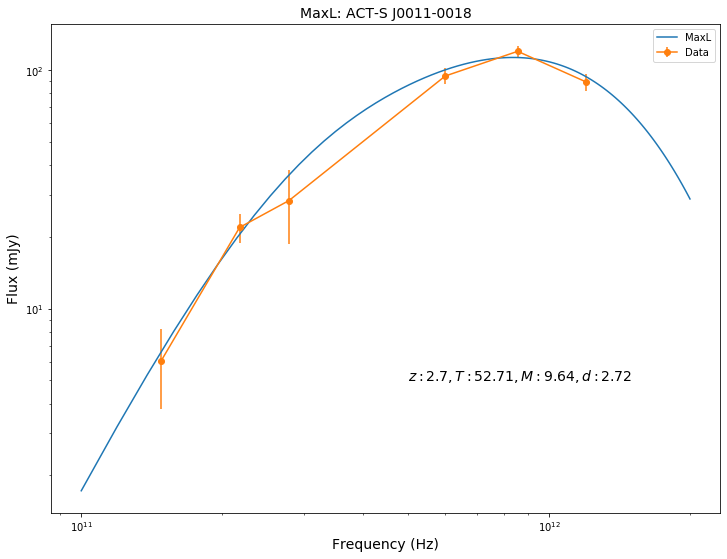

In [57]:
ml(ID[0],z_ref,T_ref,M_ref,d_ref,frecs0T,errf0T)

<Figure size 864x648 with 0 Axes>

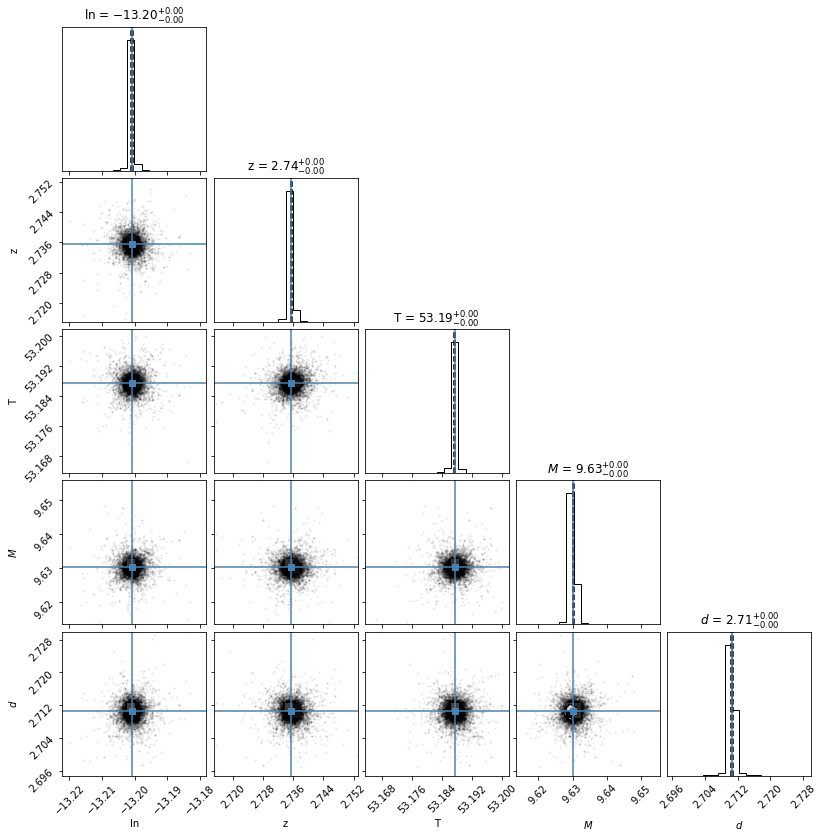

In [58]:
mcmc(ID[0],z_ref,T_ref,M_ref,d_ref,frecs0T,errf0T) #notoriamente (y obviamente) esto tarda más en correr aquí que en SPT

En este plot tipo corner notamos que: 
1) no hay ningún tipo de correlación entre ningún parámetro.
2) los valores de los parametros no son tan exactos (en rel. con los del ML) como los obtenidos para SPT mediante el mismo método
3) pese a que los valores para SPT son mejores (comparando con los de ML), estos sí tienen rangos de error jajaja:(
4) No sé porqué tanto cambio en los resultados si solo agregué un prior... por esto pienso que hay un error en el codigo de la función lnprob, que fue donde más cosas hice.

ACT-S J0022-0155

In [24]:
frecs1T=np.array([v1[1],v2[1],l1[1],l2[1],l3[1]])
errf1T=np.array([ev1[1],ev2[1],el1[1],el2[1],el3[1]])

In [25]:
frecs1=np.array([[v1[1],v2[1]],[l1[1],l2[1],l3[1]]])
errf1=np.array([[ev1[1],ev2[1]],[el1[1],el2[1],el3[1]]])

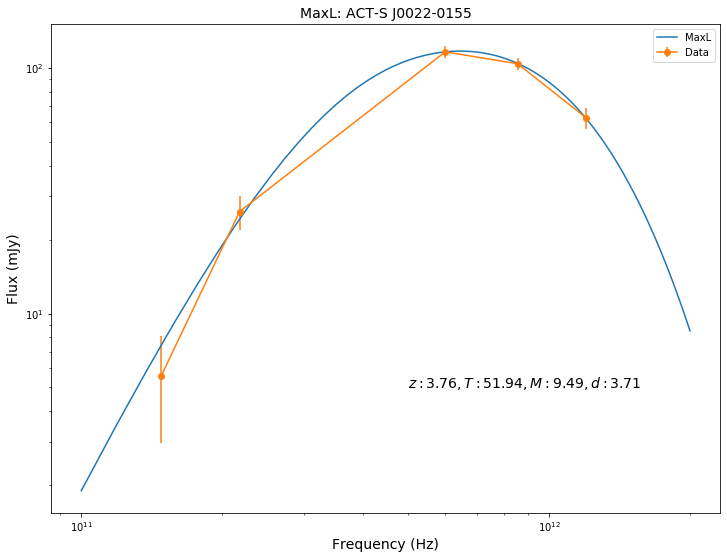

In [26]:
ml_1(ID[1],z_ref,T_ref,M_ref,d_ref,frecs1T,errf1T)

(-0.019684031792150617, -2.9943737073802996)
(-0.019684422187481943, -2.994465836472362)
(-0.019684038421227512, -2.9942538253753623)
(-0.019684039514012656, -2.9942455764199876)
(-0.019683919419306507, -2.9943381425465305)
(-0.019684396672848697, -2.9944590669226145)
(-0.019684107550914754, -2.9945719562634965)
(-0.019684377135564746, -2.9944197197284144)
(-0.01968421877199643, -2.9944308546857417)
(-0.019683933208006665, -2.994493953356699)
(-0.019684073393969118, -2.994306729182336)
(-0.019683987423404752, -2.994256896915009)
(-0.019684174500046333, -2.9945224469931575)
(-0.019683880044252675, -2.9944550475852614)
(-0.019684101574114387, -2.99449541714784)
(-0.019683874331524184, -2.9945046797361536)
(-0.019683893104111904, -2.994304665583964)
(-0.019684169654522375, -2.9942352263602143)
(-0.019683965498414353, -2.994218560990542)
(-0.01968397374598698, -2.994347376592261)
(-0.019683821184938406, -2.9943869165166146)
(-0.01968394033041123, -2.994286933073747)
(-0.019683881131847013,

<Figure size 864x648 with 0 Axes>

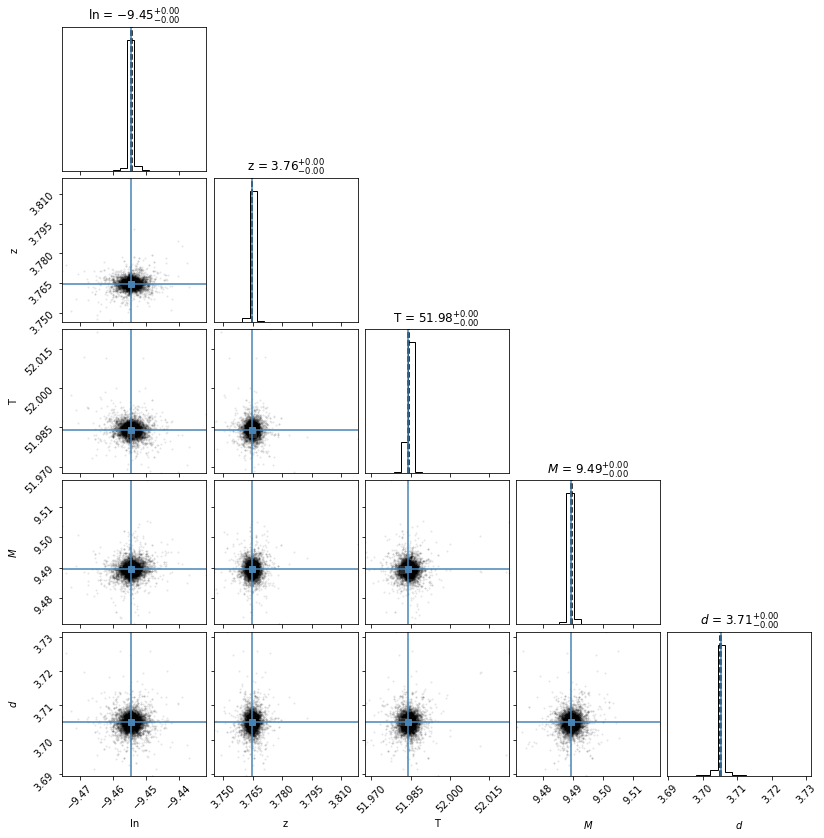

In [33]:
mcmc_1(ID[1],z_ref,T_ref,M_ref,d_ref,frecs1T,errf1T)

ACT-S J0038_0022

In [30]:
frecs2T=np.array([v1[2],v2[2],v3[2],l1[2],l2[2],l3[2]])
errf2T=np.array([ev1[2],ev2[2],ev3[2],el1[2],el2[2],el3[2]])

In [31]:
frecs2=np.array([[v1[2],v2[2],v3[2]],[l1[2],l2[2],l3[2]]])
errf2=np.array([[ev1[2],ev2[2],ev2[2]],[el1[2],el2[2],el3[2]]])

In [ ]:
mcmc(ID[2],z_ref,T_ref,M_ref,d_ref,frecs2T,errf2T)

ACT-S J0039+0024

In [ ]:
frecs3T=np.array([v1[3],v2[3],v3[3],l1[3],l2[3],l3[3]])
errf3T=np.array([ev1[3],ev2[3],ev3[3],el1[3],el2[3],el3[3]])

In [ ]:
frecs3=np.array([[v1[3],v2[3],v3[3]],[l1[3],l2[3],l3[3]]])
errf3=np.array([[ev1[3],ev2[3],ev2[3]],[el1[3],el2[3],el3[3]]])

In [ ]:
ml(ID[3],z_ref,T_ref,M_ref,d_ref,frecs3T,errf3T)

ACT-S J0044+0118

In [ ]:
frecs4T=np.array([v1[4],v2[4],v3[4],l1[4],l2[4],l3[4]])
errf4T=np.array([ev1[4],ev2[4],ev3[4],el1[4],el2[4],el3[4]])

In [ ]:
frecs4=np.array([[v1[4],v2[4],v3[4]],[l1[4],l2[4],l3[4]]])
errf4=np.array([[ev1[4],ev2[4],ev2[4]],[el1[4],el2[4],el3[4]]])

In [ ]:
z4=4.9
T4=47.2*un.K
M4_=9.42
d4_=4.9*un.kpc

In [ ]:
ml(ID[4],z_ref,T_ref,M_ref,d_ref,frecs4T,errf4T)

ACT-S J0045_0001

In [ ]:
frecs5T=np.array([v1[5],v2[5],v3[5],l1[5],l2[5],l3[5]])
errf5T=np.array([ev1[5],ev2[5],ev3[5],el1[5],el2[5],el3[5]])

In [ ]:
frecs5=np.array([[v1[5],v2[5],v3[5]],[l1[5],l2[5],l3[5]]])
errf5=np.array([[ev1[5],ev2[5],ev2[5]],[el1[5],el2[5],el3[5]]])

In [ ]:
z5=4.6
T5=39.9*un.K
M5_=9.39
d5_=4.4*un.kpc

In [ ]:
ml(ID[5],z_ref,T_ref,M_ref,d_ref,frecs5T,errf5T)

ACT-S J0107+0001 

In [ ]:
frecs6T=np.array([v1[6],v2[6],v3[6],l1[6],l2[6],l3[6]])
errf6T=np.array([ev1[6],ev2[6],ev3[6],el1[6],el2[6],el3[6]])

In [ ]:
frecs6=np.array([[v1[6],v2[6],v3[6]],[l1[6],l2[6],l3[6]]])
errf6=np.array([[ev1[6],ev2[6],ev2[6]],[el1[6],el2[6],el3[6]]])

In [ ]:
ml(ID[6],z_ref,T_ref,M_ref,d_ref,frecs6T,errf6T)

In [ ]:
ID[7]

ACT-S J0116_0004

In [ ]:
frecs7T=np.array([v1[7],v2[7],v3[7],l1[7],l2[7],l3[7]])
errf7T=np.array([ev1[7],ev2[7],ev3[7],el1[7],el2[7],el3[7]])

In [ ]:
frecs7=np.array([[v1[7],v2[7],v3[7]],[l1[7],l2[7],l3[7]]])
errf7=np.array([[ev1[7],ev2[7],ev2[7]],[el1[7],el2[7],el3[7]]])

In [ ]:
ml(ID[7],z_ref,T_ref,M_ref,d_ref,frecs7T,errf7T)

ACT-S J0210+0016 esp

In [ ]:
frecs8T=np.array([v1[8],v2[8],v3[8],l1[8],l2[8],l3[8]])
errf8T=np.array([ev1[8],ev2[8],ev3[8],el1[8],el2[8],el3[8]])

In [ ]:
frecs8=np.array([[v1[8],v2[8],v3[8]],[l1[8],l2[8],l3[8]]])
errf8=np.array([[ev1[8],ev2[8],ev2[8]],[el1[8],el2[8],el3[8]]])

In [ ]:
ml(ID[8],z_ref,T_ref,M_ref,d_ref,frecs8T,errf8T)

In [ ]:
mcmc(ID[6],z_ref,T_ref,M_ref,d_ref,frecs6T,errf6T)